## Is it possible to predict star ratings on Yelp?

This project focuses on whether business attributes like availabilty of parking, table service or reservations can be used to predict the star rating of a business on the Yelp website.

The data comes from the Yelp Open Data Set which contains 150,346 businesses with over 1.2 million attributes: https://www.yelp.com/dataset.

After cleaning the data and some basic EDA I will apply different machine learning models to find the right estimator.

### Data Cleaning

In [530]:
import pandas as pd
import json
import re
import numpy as np

In [531]:
# Some of the nested objects like 'BusinessParking' are wronlgy stored 
# with additional quotation marks around them. The quotes need to be removed
# so that the object can be correcly turned into a flat table.

data = []

with open('yelp_dataset/yelp_academic_dataset_business.json') as f:

    for line in f:
        json_dict = json.loads(line)

        if json_dict['attributes']:
            if 'BusinessParking' in json_dict['attributes'].keys():
                json_dict['attributes']['BusinessParking'] = eval(json_dict['attributes']['BusinessParking'])

        data.append(json_dict)

In [532]:
businesses = pd.json_normalize(data)

In [533]:
# Make column names lowercase and seperate words with underscore

businesses.columns = businesses.columns.str.split(('.')).str[-1]

columns = []

for column in businesses.columns:
    column = re.sub(r'(\w)([A-Z])', r'\1_\2', column)
    column = re.sub(r'Restaurants_', r'', column)
    column = re.sub(r'Business_', r'', column)
    column = re.sub(r'(Range)([0-9])', r'\1', column)
    columns.append(column.lower())

businesses.columns = columns

In [534]:
# Some attribute columns have too many missing values. We will get rid of them and also drop some other columns which we are not interested in.

businesses[businesses.columns[13:]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 52 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   by_appointment_only    42339 non-null   object 
 1   accepts_credit_cards   119765 non-null  object 
 2   monday                 114474 non-null  object 
 3   tuesday                120631 non-null  object 
 4   wednesday              123771 non-null  object 
 5   thursday               125198 non-null  object 
 6   friday                 124999 non-null  object 
 7   saturday               110770 non-null  object 
 8   bike_parking           72638 non-null   object 
 9   price_range            85314 non-null   object 
 10  coat_check             5584 non-null    object 
 11  take_out               59857 non-null   object 
 12  delivery               56282 non-null   object 
 13  caters                 40127 non-null   object 
 14  wi_fi                  56914 non-nul

In [535]:
businesses.drop(
  [
    'attributes',
    'hair_specializes_in',
    'counter_service',
    'open24_hours',
    'dietary_restrictions',
    'accepts_insurance',
    'ages_allowed',
    'b_yo_bcorkage',
    'corkage',
    'smoking',
    'b_yo_b',
    'good_for_dancing',
    'coat_check',
    'by_appointment_only',
    'best_nights',
    'music',
    'drive_thru',
    'accepts_bitcoin',
    'dogs_allowed',
    'happy_hour',
    'wheelchair_accessible',
    'good_for_meal',
    'ambience',
    'business_parking',
    'address',
    'postal_code',
    'hours',
    'is_open',
    'monday',
    'tuesday',
    'wednesday',
    'thursday',
    'friday',
    'saturday',
    'sunday',
    'latitude',
    'longitude'
  ],
  axis=1, errors='ignore', inplace=True)

In [536]:
# Remove u'...' prefix from values

businesses[['alcohol', 'noise_level', 'attire', 'wi_fi']] = businesses[['alcohol', 'noise_level', 'attire', 'wi_fi']].apply(lambda x: x.str.strip("u'"), axis=0)

In [537]:
# Parking availability has different categories which are stored in separate columns.
# Instead we want to create a new column that summarizes wheather parking is available or not in general.

def check_parking(row):
    if True in row.values:
        return 'True'
    elif False in row.values:
        return 'False'
    else:
        return np.nan
    
businesses['parking'] = businesses[['garage', 'street', 'validated', 'lot', 'valet']].apply(check_parking, axis=1)

businesses.drop(['garage', 'street','validated','lot','valet'], axis=1, inplace=True)

### Some basic EDA

In [538]:
# What are the top 20 business categories used by businesses in the data set?

from collections import Counter

businesses_categories = []

for labels in businesses['categories'].str.split(', '):
    if labels is not None:
        for label in labels:
            businesses_categories.append(label)

top_20_categories = Counter(businesses_categories).most_common(20)

In [539]:
import matplotlib.pyplot as plt

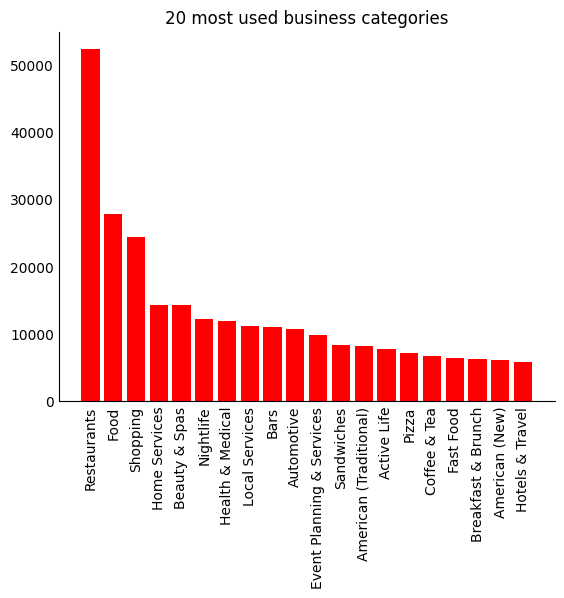

In [540]:
x = [i[0] for i in top_20_categories]
y = [i[1] for i in top_20_categories]

plt.bar(x, y, color='r')
plt.title('20 most used business categories')
plt.xticks(rotation=90)
plt.gca().spines[['right', 'top']].set_visible(False)
plt.tick_params(axis='both', length=0.0)
plt.show();

In [541]:
# 'Restaurants' is the biggest group. Let's focus on them for further analysis.

def get_restaurants(row):
    if 'Restaurants' in row:
        return True

In [542]:
businesses.dropna(subset='categories', inplace=True)
restaurants = businesses[businesses['categories'].apply(get_restaurants) == True]

In [543]:
restaurants.reset_index(drop=True, inplace=True)

In [544]:
restaurants['stars'].describe().iloc[5]

3.5

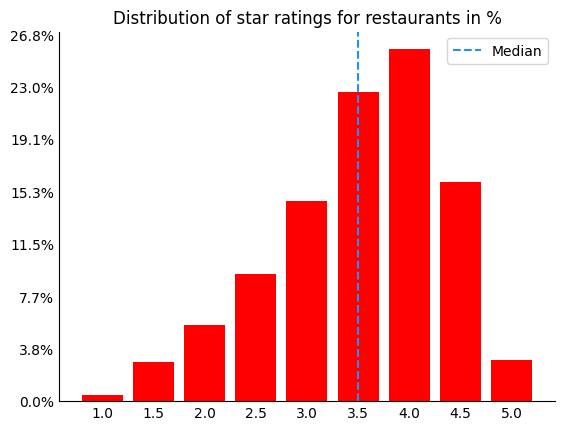

In [545]:
# What is the distrbution of star ratings? What is the median?

from matplotlib.ticker import PercentFormatter

stars = restaurants['stars'].value_counts().sort_index()

plt.bar(stars.index, stars.values, color='r', width=0.4)
plt.axvline(restaurants['stars'].describe().iloc[5], color='dodgerblue', linestyle='--', label='Median')
plt.title('Distribution of star ratings for restaurants in %')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.gca().yaxis.set_major_formatter(PercentFormatter(stars.values.sum()))
plt.xticks(np.linspace(1, 5, 9))
plt.gca().spines[['right', 'top']].set_visible(False)
plt.tick_params(axis='both', length=0.0)
plt.legend()
plt.show();


### Prediction of star ratings

There are still several rows with missing values, which can't be handled by Scitkit-learn's models. We can drop all of those rows first.

In [546]:
# In addition, columns with multiple features like 'price_range' contain 'None' values that can't be interpreted in a senseful way.
# Also, the 'None's are string objects which need to be converted to NaN values first and afterwards dropped with the other rows.

cols = ['price_range', 'attire', 'wi_fi', 'noise_level', 'alcohol']  # Columns with multiple features

for label in cols:
    restaurants.loc[restaurants[label] == 'None', label] = np.nan

restaurants = restaurants[restaurants[restaurants.columns[7:]].isna().any(axis=1) == False]

In [547]:
# Columns with binary features also contain 'None' and 'none' values. In this case we can interprete them as False and replace them with False.

restaurants = restaurants.replace(['none', 'None'], ['False', 'False'])

In [548]:
# https://medium.com/@sujathamudadla1213/target-guided-ordinal-encoding-with-example-450323fea78e  # Target encoding -> Cardinal features, ordinal target

from sklearn.preprocessing import LabelEncoder

cols = ['accepts_credit_cards', 'bike_parking', 'price_range',
       'take_out', 'delivery', 'caters', 'wi_fi', 'outdoor_seating', 'has_tv',
       'reservations', 'alcohol', 'good_for_kids', 'parking', 'attire',
       'table_service', 'good_for_groups', 'noise_level']

for col in cols:
    le = LabelEncoder()
    le.fit(restaurants[col])
    print(le.classes_, le.transform(restaurants[col]))
    restaurants[col] = le.transform(restaurants[col])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)

['False' 'True'] [1 1 1 ... 1 1 1]
{'False': 0, 'True': 1}
['False' 'True'] [1 1 1 ... 0 1 1]
{'False': 0, 'True': 1}
['1' '2' '3' '4'] [0 0 1 ... 2 1 2]
{'1': 0, '2': 1, '3': 2, '4': 3}
['False' 'True'] [1 1 1 ... 1 1 0]
{'False': 0, 'True': 1}
['False' 'True'] [1 0 1 ... 1 1 0]
{'False': 0, 'True': 1}
['False' 'True'] [1 1 1 ... 1 0 0]
{'False': 0, 'True': 1}
['free' 'no' 'paid'] [1 1 0 ... 0 0 0]
{'free': 0, 'no': 1, 'paid': 2}
['False' 'True'] [0 0 1 ... 0 1 0]
{'False': 0, 'True': 1}
['False' 'True'] [1 1 1 ... 1 1 1]
{'False': 0, 'True': 1}
['False' 'True'] [0 0 1 ... 1 0 1]
{'False': 0, 'True': 1}
['False' 'beer_and_wine' 'full_bar'] [0 0 2 ... 2 1 2]
{'False': 0, 'beer_and_wine': 1, 'full_bar': 2}
['False' 'True'] [1 1 1 ... 1 1 1]
{'False': 0, 'True': 1}
['False' 'True'] [1 1 1 ... 1 1 1]
{'False': 0, 'True': 1}
['casual' 'dressy' 'formal'] [0 0 0 ... 0 0 1]
{'casual': 0, 'dressy': 1, 'formal': 2}
['False' 'True'] [0 1 1 ... 1 0 1]
{'False': 0, 'True': 1}
['False' 'True'] [0 0

In [549]:
# restaurants['alcohol'].replace(['False', 'beer_and_wine', 'full_bar'], [0, 1, 2], inplace=True)
# restaurants['attire'].replace(['casual', 'dressy', 'formal'], [0, 1, 2], inplace=True)
# restaurants['wi_fi'].replace(['no', 'paid', 'free'], [0, 1, 2], inplace=True)
# restaurants['noise_level'].replace(['quiet', 'average', 'loud', 'very_loud'], [0, 1, 2, 3], inplace=True)

In [550]:
# cols = [
#     'accepts_credit_cards',
#     'bike_parking', 'take_out', 'delivery', 'caters',
#     'outdoor_seating', 'has_tv', 'reservations',
#     'good_for_kids', 'parking', 'table_service',
#     'good_for_groups']

# for label in cols:
#     restaurants[label] = (restaurants[label] == 'True').astype(int)  # Encodes True as 1, False as 0

In [517]:
# restaurants['price_range'] = restaurants['price_range'].astype(int)
# restaurants['stars'] = restaurants['stars'].astype(int)

In [551]:
restaurants['stars'].dtype

dtype('float64')

In [552]:
train, valid, test = np.split(restaurants.sample(frac=1), [int(0.6*len(restaurants)), int(0.8*len(restaurants))])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [553]:
def split_X_y(dataframe, oversample=False):
    X = dataframe[dataframe.columns[7:]].values
    y = dataframe['stars'].values

    # if oversample:
    #     ros = RandomOverSampler()
    #     X, y = ros.fit_resample(X, y)

    return X, y

In [554]:
X_train, y_train = split_X_y(train, oversample=False)
X_test, y_test = split_X_y(test, oversample=False)

In [555]:
from sklearn.linear_model import LogisticRegression

In [556]:
lg_model = LogisticRegression(multi_class='multinomial')
lg_model.fit(X_train, y_train)

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [474]:
y_pred  = lg_model.predict(X_test)

In [475]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        17
           2       0.50      0.10      0.17       191
           3       0.51      0.26      0.34       859
           4       0.59      0.88      0.71      1291
           5       0.00      0.00      0.00        26

    accuracy                           0.58      2384
   macro avg       0.32      0.25      0.24      2384
weighted avg       0.55      0.58      0.52      2384



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [476]:
from sklearn.neighbors import KNeighborsClassifier

In [478]:
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)

KNeighborsClassifier()

In [479]:
y_pred = neigh.predict(X_test)

In [480]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.17      0.06      0.09        17
           2       0.35      0.29      0.32       191
           3       0.43      0.44      0.43       859
           4       0.62      0.64      0.63      1291
           5       0.00      0.00      0.00        26

    accuracy                           0.53      2384
   macro avg       0.31      0.29      0.29      2384
weighted avg       0.52      0.53      0.52      2384



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [481]:
import tensorflow as tf

2024-01-18 17:52:43.128592: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [482]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation= 'relu', input_shape=(17,)),
    tf.keras.layers.Dense(32, activation= 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [483]:
history = nn_model.fit(
    X_train,
    y_train,
    epochs=100,  # epoch = training cycle
    batch_size=32,
    validation_split=0.2  # ??Uses some part of the data to validate the model
)

Epoch 1/100
179/179 [==============================] - 2s 4ms/step - loss: -161.2111 - accuracy: 0.0075 - val_loss: -641.2247 - val_accuracy: 0.0077
Epoch 2/100
179/179 [==============================] - 0s 3ms/step - loss: -2514.6519 - accuracy: 0.0075 - val_loss: -5550.2183 - val_accuracy: 0.0077
Epoch 3/100
179/179 [==============================] - 1s 3ms/step - loss: -11263.5596 - accuracy: 0.0075 - val_loss: -18927.1289 - val_accuracy: 0.0077
Epoch 4/100
179/179 [==============================] - 0s 3ms/step - loss: -30151.4336 - accuracy: 0.0075 - val_loss: -44215.6094 - val_accuracy: 0.0077
Epoch 5/100
179/179 [==============================] - 1s 3ms/step - loss: -62592.0234 - accuracy: 0.0075 - val_loss: -84797.0625 - val_accuracy: 0.0077
Epoch 6/100
179/179 [==============================] - 1s 3ms/step - loss: -111438.4531 - accuracy: 0.0075 - val_loss: -143048.3750 - val_accuracy: 0.0077
Epoch 7/100
179/179 [==============================] - 1s 3ms/step - loss: -178755.078

In [484]:
def plot_loss(history):

    fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(10, 4))

    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary crossentropy')
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Binary crossentropy')
    ax2.grid(True)

    plt.show()

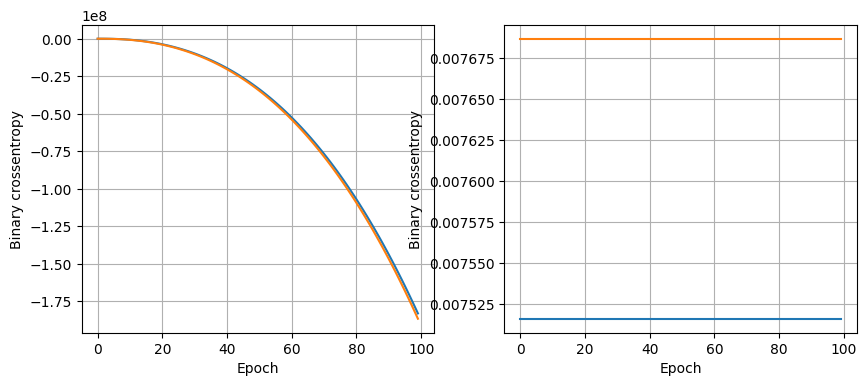

In [485]:
plot_loss(history)

In [ ]:
for label in restaurants.columns[9:]:
    display(pd.crosstab(restaurants[label][restaurants[label].notna()], restaurants['stars'][restaurants[label].notna()], margins=True, normalize='columns'))

In [ ]:
from sklearn.feature_selection import f_regression

In [ ]:
data_table_service = restaurants[['table_service', 'stars']][restaurants['table_service'].notna()]

In [ ]:
data_table_service

In [ ]:
data_table_service['table_service'] = (data_table_service['table_service'] == 'True').astype(int)

In [ ]:
X = np.reshape(data_table_service['table_service'], (-1, 1))
y = data_table_service['stars']

In [ ]:
y

In [ ]:
data_table_service['stars']

In [ ]:
f_statistic, p_values = f_regression(X, y)

In [ ]:
f_statistic

In [ ]:
for i in range(len(f_statistic)):
    print(f"Feature {i + 1}: F-statistic = {f_statistic[i]}, P-value = {p_values[i]}")

In [ ]:
with open('tables/restaurants_pennsylvania.csv', 'w') as f:
    restaurants.to_csv(f, header=True, index=False)

### We have created a table with all restaurants in Pennsylvania and saved it in a .csv for later analysis

### Now we load the table with all reviews and create a .csv which only contains reviews from restaurants in Pennsylvania

In [ ]:
businesses_ids = restaurants['business_id'].to_list()

column_names = ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']

chunks = pd.read_json('yelp_dataset/yelp_academic_dataset_review.json', lines=True, chunksize=100000)

with open('tables/reviews_pennsylvania.csv', 'w') as f:
    header = ','.join(column_names)
    f.write(header + '\n')

    for chunk in chunks:
        reviews = pd.DataFrame(chunk)
        
        reviews[reviews['business_id'].isin(businesses_ids)].to_csv(f, mode='a', header=False, index=False)

### Analysis starts here

In [ ]:
restaurants = get_file('tables/restaurants_pennsylvania.csv')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(5, 5))

# fig.suptitle('Customer ratings', fontsize=16)

sns.barplot(
    ax = ax,
    x=restaurants['stars'].value_counts().sort_index().index,
    y=restaurants['stars'].value_counts().sort_index().values*100/restaurants['stars'].value_counts().sort_index().values.sum(),
    color='#FF1A1A'
)
ax.set(xlabel='Stars', ylabel='No. of businesses in %')
ax.set_title('Star ratings');

In [ ]:
restaurants[[
    'stars',
    'accepts_credit_cards',
    'bike_parking',
    'price_range',
    'take_out',
    'delivery',
    'caters',
    'wi_fi',
    'outdoor_seating',
    'has_tv',
    'reservations',
    'alcohol',
    'good_for_kids',
    'attire',
    'table_service',
    'good_for_groups',
    'noise_level',
    'parking_available'
]].corr(method='spearman')

In [ ]:
reviews = get_file('tables/reviews_pennsylvania.csv')

In [ ]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_md')
nlp.add_pipe('spacytextblob')

def check_polarity(text):
    doc = nlp(text)
    return doc._.blob.polarity

reviews['polarity'] = reviews['text'][:10000].apply(lambda x: check_polarity(x))

In [ ]:
with open('tables/reviews_polarity.csv', 'w') as f:
    reviews[:10000].to_csv(f, header=True, index=False)

In [ ]:
reviews = get_file('tables/reviews_polarity.csv')

In [ ]:
negative_reviews = reviews[reviews['polarity'] < 0]

### Analys negative reviews

#### We want to find statements about food

In [ ]:
# Training the entity rule to recognize food

food = pd.read_csv('food_labels/food.csv')

In [ ]:
food_labels = food[food['description'].str.contains('[a-zA-Z]') == True]['description']

In [ ]:
food_labels = food_labels[food_labels.str.split().apply(len) <= 2].drop_duplicates()

In [ ]:
food_labels = food_labels.str.lower()

In [ ]:
food_labels = food_labels[food_labels.str.contains('.*,.*,.*', regex=True) == False]

In [ ]:
# Fix: Foods are comma seperated and order is reversed: 'muffins, blueberry' become 'blueberry muffins'

food_labels[food_labels.str.contains(', ') == True] = (
    food_labels[food_labels.str.contains(', ') == True].str.split(', ', expand=True)[1] +
    ' ' +
    food_labels[food_labels.str.contains(', ') == True].str.split(', ', expand=True)[0]
)

food_labels[food_labels.str.contains(',') == True] = (
    food_labels[food_labels.str.contains(',') == True].str.split(',', expand=True)[1] +
    ' ' +
    food_labels[food_labels.str.contains(',') == True].str.split(',', expand=True)[0]
)

In [ ]:
# If label has no plural, create singular form. If label has no singular, create plural 

import spacy
import lemminflect

nlp = spacy.load('en_core_web_lg')

inflected_labels = []

for label in food_labels:
    
    doc = nlp(label)

    if len(doc) == 1:
        if doc[0].tag_ == 'NNS':
            inflected_labels.append(doc[0]._.inflect('NN'))
        else:
            inflected_labels.append(doc[0]._.inflect('NNS'))

    if len(doc) == 2:
        if doc[1].tag_ == 'NNS':
            inflected_labels.append(doc[0].text + ' ' + doc[1]._.inflect('NN'))
        else:
            inflected_labels.append(doc[0].text + ' ' + doc[1]._.inflect('NNS'))

In [ ]:
food_labels_inflected = pd.Series(inflected_labels)

In [ ]:
food_labels = pd.concat([food_labels, food_labels_inflected])

In [ ]:
food_labels.drop_duplicates(inplace=True)

In [ ]:
food_labels[food_labels.str.contains('bar', regex=True)]

In [ ]:
# Add food labels to entity ruler

food_labels = food_labels  # Remove 'bar' from foods_labels, add 'product'

patterns = []

nlp = spacy.load('en_core_web_lg')

ruler = nlp.add_pipe('entity_ruler', before='ner')

for label in food_labels:
    patterns.append({'label': 'FOOD', 'pattern': label})

ruler.add_patterns(patterns)

In [ ]:
len(patterns)

In [ ]:
ruler.to_disk('food_labels/food_patterns.jsonl')

In [ ]:
nlp = spacy.load('en_core_web_lg')

ruler = nlp.add_pipe("entity_ruler", before='ner')

ruler.from_disk('food_labels/food_patterns.jsonl')